### ▶️ Wir laden ein paar Python-Bibliotheken

In [2]:
import pandas as pd
import datetime
from IPython.display import display, HTML

### ▶️ Einlesen der vorbereiteten Daten vom Google-Drive

#### ⚠️Dieser Vorgang kann bis zu einer Minute dauern!⚠️
---

- Der Datensatz enthält alle Klimadaten von 20-01-2014 bis 20-01-2024 also der letzten zehn Jahre
- Er enthält "Mittlere (Tages)-Temperatur", "Sonnenscheindauer" und "(Mittlere)-Windgeschwindigkeit"
- Die .csv-Datei beinhaltet über 3 Millionen Datenpunkte und ist etwa 200 MegaByte gross

In [79]:
# Importiere die .csv-Datei mit den gesamten Klimadaten
df = pd.read_csv('https://drive.usercontent.google.com/download?id=11DYEiMTRVhMySsH5r3cDfCWBU2mqlNqO&export=download&authuser=0&confirm=t&uuid=1aa8951f-3209-4a18-986c-229dfc0f29e2&at=APZUnTVUwg__SVFWwQUEz9ft2zsy:1705864211167', index_col=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861377 entries, 0 to 3861376
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Zeitstempel  object 
 1   Wert         float64
 2   Kategorie    object 
 3   Station      object 
dtypes: float64(1), object(3)
memory usage: 117.8+ MB


### ▶️ Zunächst müssen wir wieder ein paar Datentypen konvertieren

In [81]:
# Konvertiere "Zeitstempel" nach dateTime
df['Zeitstempel'] = pd.to_datetime(df.Zeitstempel)

# Konvertiere "Station" nach String
df['Station'] = df['Station'].astype("string")

# Konvertiere "Produkt_Titel" nach String
df['Kategorie'] = df['Kategorie'].astype("string")


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Erstes Teilkriterium ist die gewünschte Temperatur

☑️ Die mittlere Tagestemperatur soll in den Sommermonaten von 01. Juni bis 31. August die 25°C nicht überschritten haben in den letzten drei Jahren

In [213]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Mittlere Tagestemperatur kleiner 25°C" in allen Jahren seit 2021
df_last_three_years = df.loc[((df['Kategorie'] == "Mittlere Temperatur") & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]

######################################

# Danach limitieren wir die Daten auf den meteorologischen Sommer von 01. Juni bis 31. August in jedem Jahr
df_summer = df_last_three_years.loc[((df_last_three_years['Zeitstempel'].dt.strftime('%m') >= '06') & (df_last_three_years['Zeitstempel'].dt.strftime('%m') < '09') & (df['Wert'] <= 25.0))]
df_summer = df_summer.sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)
#print(df_summer.head())

######################################

# Jeder Name einer Station darf nur einmal vorkommen
df_places = df_summer[~df_summer.duplicated(subset=['Station'])].copy()

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_places = df_places.loc[:, ['Station']].sort_values(by=('Station'), ascending=True).reset_index(drop=True)

# Auskommentieren für eine Liste aller Orte
#for i in range(len(df_places)):
#    print("Ort" + str([i+1]) + ":" + df_places['Station'][i])

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
df_criteria_1 = pd.merge(df_last_three_years, df_places, how="inner", on=['Station']).sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

df_criteria_1.head()

,Zeitstempel,Wert,Kategorie,Station
0,2021-01-01,1.6,Mittlere Temperatur,Aachen-Orsbach
1,2021-01-02,0.9,Mittlere Temperatur,Aachen-Orsbach
2,2021-01-03,1.2,Mittlere Temperatur,Aachen-Orsbach
3,2021-01-04,0.5,Mittlere Temperatur,Aachen-Orsbach
4,2021-01-05,0.7,Mittlere Temperatur,Aachen-Orsbach
5,2021-01-06,1.2,Mittlere Temperatur,Aachen-Orsbach
6,2021-01-07,0.2,Mittlere Temperatur,Aachen-Orsbach
7,2021-01-08,0.0,Mittlere Temperatur,Aachen-Orsbach
8,2021-01-09,-0.5,Mittlere Temperatur,Aachen-Orsbach
9,2021-01-10,-0.3,Mittlere Temperatur,Aachen-Orsbach


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Zweites Teilkriterium ist die gewünschte Sonnenscheindauer

☑️ Die Sonnenscheindauer soll an mindestens 200 Tagen pro Jahr 10 Stunden oder mehr betragen haben in den letzten drei Jahren

In [217]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Sonnenscheindauer" in allen Jahren seit 2021
df_sun_last_three_years = df.loc[((df['Kategorie'] == "Sonnenscheindauer") & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]
#df_sun_last_three_years.head()

######################################

# Die Sonne muss mindestens 10 Stunden geschienen haben
df_four_hours = df_sun_last_three_years.query('Wert >= 10.0')

# Wir zählen alle Tage an denen dies der Fall war und gruppieren nach Station
df_four_hours = df_four_hours.groupby('Station')[['Wert']].agg(['count']).reset_index()

######################################

# Auflösen der Mulit-Index Spalte in eine
df_four_hours.columns = ["_".join(c) for c in df_four_hours.columns]

# Dann umbennen in etwas sinnvolles
df_four_hours = df_four_hours.rename(columns={'Station_':'Station', 'Wert_count':'Anzahl'})

######################################

# An mindestens 200 Tagen wollen wir mindestens 10 Stunden Sonnenschein
df_hundred_times = df_four_hours.query('Anzahl >= 200').sort_values(by=('Anzahl'), ascending=False).reset_index(drop=True)

#print(df_hundred_times.head())

######################################

# Wir erhalten ein Data-Frame nur mit den Stationen welche die Kriterien erfüllen
df_sun_places = df_hundred_times.loc[:, ['Station']].sort_values(by=('Station'), ascending=True).reset_index(drop=True)

# Auskommentieren für eine Liste aller Orte
#for i in range(len(df_sun_places)):
 #   print("Ort" + str([i+1]) + ":" + df_sun_places['Station'][i])

######################################

# Aus den Datensätzen der letzten drei Jahre wollen wir nur die Stationen welche die Kriterien erfüllen
df_criteria_2 = pd.merge(df_sun_last_three_years, df_sun_places, how="inner", on=['Station']).sort_values(by=(['Station', 'Zeitstempel']), ascending=True).reset_index(drop=True)

df_criteria_2.head()

,Zeitstempel,Wert,Kategorie,Station
0,2021-01-01,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
1,2021-01-02,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
2,2021-01-03,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
3,2021-01-04,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"
4,2021-01-05,0.0,Sonnenscheindauer,"Altheim, Kreis Biberach"


### ▶️ Suchen von zehn möglichen Wohnorten die unsere drei Kriterien erfüllen

#### Drittes Teilkriterium ist die gewünschte Windgeschwindigkeit

☑️ Die mittlere Windgeschwindigkeit soll an mindestens 100 Tagen pro Jahr unter 2 m/s betragen haben in den letzten drei Jahren


In [ ]:
# Wir filtern den gesamten Datensatz nach den Kriterien "Mittlere Windgeschwindigkeit kleiner als 2 m/s" in allen Jahren seit 2021
#df_wind = df.loc[((df['Kategorie'] == "Windgeschwindigkeit") & (df['Wert'] < 2.0) & (df['Zeitstempel'].dt.strftime('%Y') >= '2021'))]
#df_wind.set_index("Zeitstempel", inplace=True)

#df_places.head()

In [81]:
# Get the calculations for "min", "max", "mean", "var" and "std" for all stations, sorted by "std"
# Legend :
# "min"  --> minmial temperatures during the last 3 years of all german weather stations
# "max"  --> maximal temperatures during the last 3 years of all german weather stations
# "mean" --> median  temperatures during the last 3 years of all german weather stations
# "var"  --> variance values during the last 3 years of all german weather stations
# "std"  --> standard deviation values during the last 3 years of all german weather stations

df_calc_temp = df_temp.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).reset_index()
df_calc_sun = df_sun.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).reset_index()
df_calc_wind = df_wind.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).dropna().reset_index()

df_calc_temp.columns = ["_".join(c) for c in df_calc_temp.columns]
df_calc_temp = df_calc_temp.rename(columns={'Wert_min':'Temperatur [min]', 'Wert_max':'Temperatur [max]', 'Wert_mean':'Temperatur [mean]'})
df_calc_temp = df_calc_temp.rename(columns={'Station_': 'Station', 'Wert_var':'Temperatur [var]', 'Wert_std':'Temperatur [std]'})

df_calc_sun.columns = ["_".join(c) for c in df_calc_sun.columns]
df_calc_sun = df_calc_sun.rename(columns={'Wert_min':'Sonne [min]', 'Wert_max':'Sonne [max]', 'Wert_mean':'Sonne [mean]'})
df_calc_sun = df_calc_sun.rename(columns={'Station_': 'Station', 'Wert_var':'Sonne [var]', 'Wert_std':'Sonne [std]'})

df_calc_wind.columns = ["_".join(c) for c in df_calc_wind.columns]
df_calc_wind = df_calc_wind.rename(columns={'Wert_min':'Wind [min]', 'Wert_max':'Wind [max]', 'Wert_mean':'Wind [mean]'})
df_calc_wind = df_calc_wind.rename(columns={'Station_': 'Station', 'Wert_var':'Wind [var]', 'Wert_std':'Wind [std]'})

#print(df_calc_wind.columns)

df_result = pd.merge(df_calc_temp, df_calc_sun, on="Station")
df_result = pd.merge(df_result, df_calc_wind, on="Station")

#print(df_result.columns)

def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


# Show a sample
df_result = df_result[0:10]
df_result.head(10).style.bar(subset=('Temperatur [std]'), color='blue').bar(subset=('Sonne [std]'), color='#7715ea').bar(subset=('Wind [std]'), color='#074bf8')

,Station,Temperatur [min],Temperatur [max],Temperatur [mean],Temperatur [var],Temperatur [std],Sonne [min],Sonne [max],Sonne [mean],Sonne [var],Sonne [std],Wind [min],Wind [max],Wind [mean],Wind [var],Wind [std]
0,UFS TW Ems,0.700000,20.700000,10.551172,22.917689,4.787242,4.017000,16.400000,8.608063,10.510199,3.241944,1.600000,1.900000,1.775000,0.022500,0.150000
1,UFS Deutsche Bucht,0.900000,21.700000,11.940238,23.181252,4.814691,4.033000,16.300000,8.886109,9.819489,3.133606,1.300000,1.900000,1.700000,0.120000,0.346410
2,Berlin-Tegel,-9.100000,14.400000,3.803226,24.081290,4.907269,4.500000,13.900000,7.837500,6.495737,2.548674,1.000000,1.900000,1.593750,0.056625,0.237960
3,Helgoland,-3.100000,22.400000,10.612776,30.143691,5.490327,4.017000,15.717000,8.752615,10.160672,3.187581,1.600000,1.900000,1.760000,0.018000,0.134164
4,Leuchtturm Alte Weser,-3.300000,23.900000,10.555386,33.844270,5.817583,4.033000,15.833000,8.991631,10.119045,3.181045,1.700000,1.900000,1.800000,0.020000,0.141421
5,Norderney,-3.800000,23.700000,10.689946,34.317329,5.858099,4.017000,16.250000,8.945423,10.349364,3.217043,1.800000,1.900000,1.833333,0.003333,0.057735
6,Schönhagen (Ostseebad),-5.900000,23.400000,9.847175,37.789370,6.147306,4.033000,16.267000,8.984544,10.003773,3.162874,1.300000,1.900000,1.738889,0.035458,0.188302
7,Emden,-6.700000,24.600000,10.390673,37.823557,6.150086,4.017000,15.767000,8.346768,9.327518,3.054099,1.100000,1.900000,1.677465,0.038628,0.196539
8,Wittmundhafen,-6.800000,24.400000,9.965282,37.934376,6.159089,4.100000,14.200000,7.635526,7.920988,2.814425,1.000000,1.900000,1.576250,0.056517,0.237734
9,Dörpen,-5.500000,25.000000,10.755717,38.080998,6.170980,4.017000,15.867000,8.521372,9.768469,3.125455,0.700000,1.900000,1.561932,0.076657,0.276870


<Figure size 2500x1000 with 0 Axes>

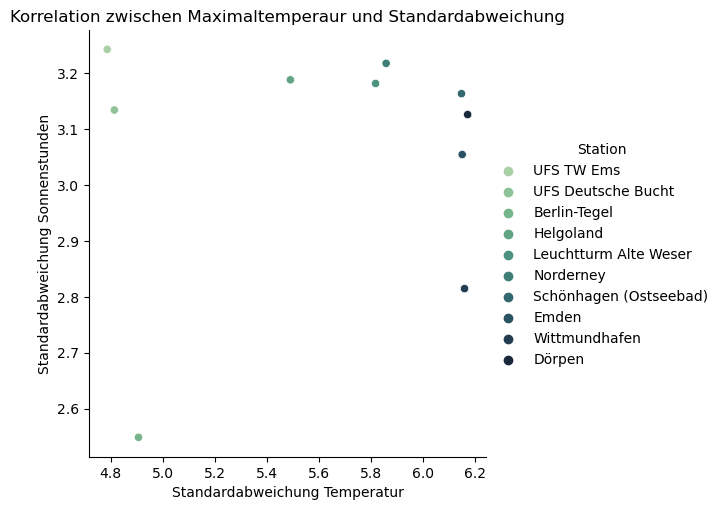

In [57]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(25,10))

plot = sns.relplot(data=df_result, x=df_result[('Temperatur [std]')], y=df_result['Sonne [std]'], hue="Station", palette="ch:r=-.5,l=.75")
plot.set(title="Korrelation zwischen Maximaltemperaur und Standardabweichung", xlabel="Standardabweichung Temperatur", ylabel="Standardabweichung Sonnenstunden");


In [104]:
#df_rolling = df_temp.reset_index(drop=True)
#df_rolling.set_index("Zeitstempel", inplace=True)


df_station_1 = df_temp.loc[(df_temp['Station'] == "Wittmundhafen")]




#df_rolling = df_temp.groupby(["Station", df_mean["Zeitstempel"].dt.year, df_mean["Zeitstempel"].dt.month])[["Wert"]].mean()
#df_calc_temp = df_temp.groupby(["Station"])[["Wert"]].agg(['min', 'max', 'mean', 'var', 'std']).sort_values(by=('Wert','std'),ascending=True).reset_index()

df_station_1.set_index("Zeitstempel", inplace=True)
df_station_1.head()


,Wert,Kategorie,Station
Zeitstempel,,,
2021-01-01,2.7,Mittlere Temperatur,Wittmundhafen
2021-01-02,3.8,Mittlere Temperatur,Wittmundhafen
2021-01-03,3.4,Mittlere Temperatur,Wittmundhafen
2021-01-04,2.3,Mittlere Temperatur,Wittmundhafen
2021-01-05,2.3,Mittlere Temperatur,Wittmundhafen


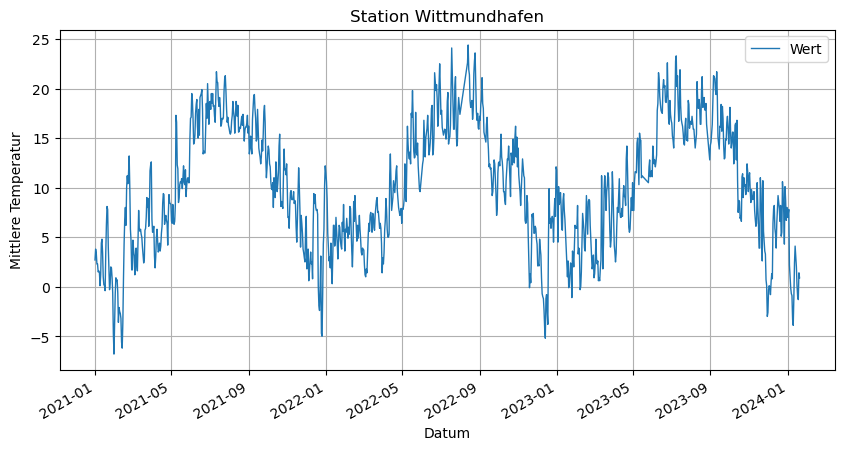

In [105]:

df_station_1.plot(y='Wert', figsize=(10,5), linewidth=1.0)
plt.xlabel('Datum')
plt.grid(True)
plt.ylabel('Mittlere Temperatur')
plt.title('Station Wittmundhafen')
plt.show()
